## Дмитрий Ильин
# Предложения по модификации модели стачечного движения

In [757]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Введение

За основу для модификации взята система нормированных уравнений из оригинальной работы:

\begin{equation*}
 \begin{cases}
     \frac{dX}{dt} = -X + X \cdot Y\\
     \frac{dY}{dt} = Y - X \cdot Y + a \cdot Y^2 - Y \cdot Z\\
     \frac{dZ}{dt} = b - m \cdot (c-Y) \cdot Z
 \end{cases}
\end{equation*}

Где:

X - индекс активности властей в подавлении стачек\
Y - число агитаторов\
Z - число бастующих рабочих

a - коэффициент вклада в рост агитации попарных связей между агитаторами\
b - вклад каждодневных причин, которые подталкивают рабочего к стачке\
c - значение сдерживающих факторов в отстутствии агитации\
m - эффективность агитации

Ниже будет рассмотрено **две** модификации этой модели, а также их сравнение с оригинальной.

Но сначала объявим вспомогательные функции, которые позволят автоматизировать расчет значений и построение графиков.

In [758]:
def calculate_values(params, xf, yf, zf, X_start=0.6, Y_start=1.4, Z_start=0.4, dt=0.0005, max_t=100):
    n_steps = round(max_t / dt)
    
    X_arr = np.zeros(n_steps + 1)
    X_arr[0] = X_start
    
    Y_arr = np.zeros(n_steps + 1)
    Y_arr[0] = Y_start
    
    Z_arr = np.zeros(n_steps + 1)
    Z_arr[0] = Z_start
    
    t_arr = np.zeros(n_steps + 1)
    
    for i in range(1, n_steps + 1):
        t = t_arr[i-1]
        X = X_arr[i-1]
        Y = Y_arr[i-1]
        Z = Z_arr[i-1]
        
        dXdt = xf(X, Y, Z, params)
        dYdt = yf(X, Y, Z,  params)
        dZdt = zf(X, Y, Z, params)
        
        t_arr[i] = t + dt
        X_arr[i] = X + dt*dXdt
        Y_arr[i] = Y + dt*dYdt
        Z_arr[i] = Z + dt*dZdt
    
    return {'X': X_arr, 'Y': Y_arr, 'Z': Z_arr, 't': t_arr, 'params': params}

In [759]:
def get_phase_diagram(values, fig, nrows=1, ncols=1, index=1, title=None, color='C0'):
    ax = fig.add_subplot(nrows, ncols, index, projection='3d')
    ax.set_xlabel('X', fontsize=16)
    ax.set_ylabel('Y', fontsize=16)
    ax.set_zlabel('Z', fontsize=16)
    ax.plot(values['X'], values['Y'], values['Z'], linewidth = 0.7, color=color)
    if color == 'C3':
        dotcolor = 'C0'
    else:
        dotcolor = 'C3'
    ax.scatter(X[0], Y[0], Z[0], color=dotcolor, s=10)
    if title is not None:
        ax.set_title(title, y=-0.07)
    
    return ax

In [760]:
def get_diagram(values, var, fig, nrows=1, ncols=1, index=1, title=None, color='C0'):
    ax = fig.add_subplot(nrows, ncols, index)
    ax.set_xlabel('t', fontsize=14)
    ax.plot(values['t'], values[var], linewidth = 0.7, color=color)
    ax.set_ylabel(var, fontsize=14, rotation=0, labelpad=15)
        
    if title is not None:
        ax.set_title(title, y=-0.07)
    
    return ax

In [761]:
def get_strike_diagram(values, fig, nrows=1, ncols=1, index=1, title=None, color='C0'):
    get_diagram(values, 'Z', fig, nrows, ncols, index, title, color)

In [762]:
def get_title(title, params=None):
    if params is not None:
        title = title + '\n' + ', '.join([str(x) + '=' + str(params[x]) for x in params.keys()]).replace('.', ',')
    return title

После объявления функций необходимо рассчитать значения X, Y, Z для оригинальной модели с различными параметрами.\
Рассчитанные значения позже будут использованы для сравнения с модифицированными вариантами.

In [763]:
def xf(X, Y, Z, params):
    return -X + X*Y

In [764]:
def yf(X, Y, Z, params):
    return Y - X*Y + params['a']*(Y**2) - Y*Z

In [765]:
def zf(X, Y, Z, params):
    return params['b'] - params['m']*(params['c'] - Y)*Z

In [766]:
orig_focus = calculate_values({'a': 0.2, 'b': 3, 'c': 1.6, 'm': 30}, xf, yf, zf)
orig_limit_cycle_a = calculate_values({'a': 0.2, 'b': 0.6, 'c': 1.6, 'm': 30}, xf, yf, zf)
orig_limit_cycle_b = calculate_values({'a': 0.2, 'b': 0.1, 'c': 0.6, 'm': 30}, xf, yf, zf, max_t=50)
orig_strange_attractor_a = calculate_values({'a': 0.2, 'b': 0.1, 'c': 1.5, 'm': 30}, xf, yf, zf, max_t=200)
orig_strange_attractor_b = calculate_values({'a': 0.2, 'b': 0.1, 'c': 6, 'm': 30}, xf, yf, zf, max_t=200)

# 2. Модификация первая: влияние числа бастующих рабочих на активность властей

Смысл первой модификации заключается в том что власти будут не только реагировать на рост числа агитаторов Y, но еще и на рост числа бастующих рабочих Z.\
Да, борьба с агитаторами как причиной роста протестной активности является эффективной мерой, однако мне кажется что масштаб самих протестов также должен оказывать должное впечатление на власти.\
Добавим в первое уравнение переменную Z и коэффициент d, описывающий насколько сильно число бастующих будет влиять на активность властей.

\begin{equation*}
 \begin{cases}
     \frac{dX}{dt} = -X + X \cdot Y + d \cdot Z \\
     \frac{dY}{dt} = Y - X \cdot Y + a \cdot Y^2 - Y \cdot Z\\
     \frac{dZ}{dt} = b - m \cdot (c-Y) \cdot Z
 \end{cases}
\end{equation*}

Рассчитаем значения X, Y, Z и перейдем к сравнению.

In [767]:
def xf_with_z(X, Y, Z, params):
    return -X + X*Y + params['d']*Z

In [768]:
x_with_z_focus = calculate_values({'a': 0.2, 'b': 3, 'c': 1.6, 'm': 30, 'd': 2}, xf_with_z, yf, zf)
x_with_z_limit_cycle_a = calculate_values({'a': 0.2, 'b': 0.6, 'c': 1.6, 'm': 30, 'd': 2}, xf_with_z, yf, zf)
x_with_z_limit_cycle_b = calculate_values({'a': 0.2, 'b': 0.1, 'c': 0.6, 'm': 30, 'd': 2}, xf_with_z, yf, zf, max_t=50)
x_with_z_strange_attractor_a = calculate_values({'a': 0.2, 'b': 0.1, 'c': 1.5, 'm': 30, 'd': 2}, xf_with_z, yf, zf, max_t=200)
x_with_z_strange_attractor_b = calculate_values({'a': 0.2, 'b': 0.1, 'c': 6, 'm': 30, 'd': 2}, xf_with_z, yf, zf, max_t=200)

### 2.1. Устойчивая точка

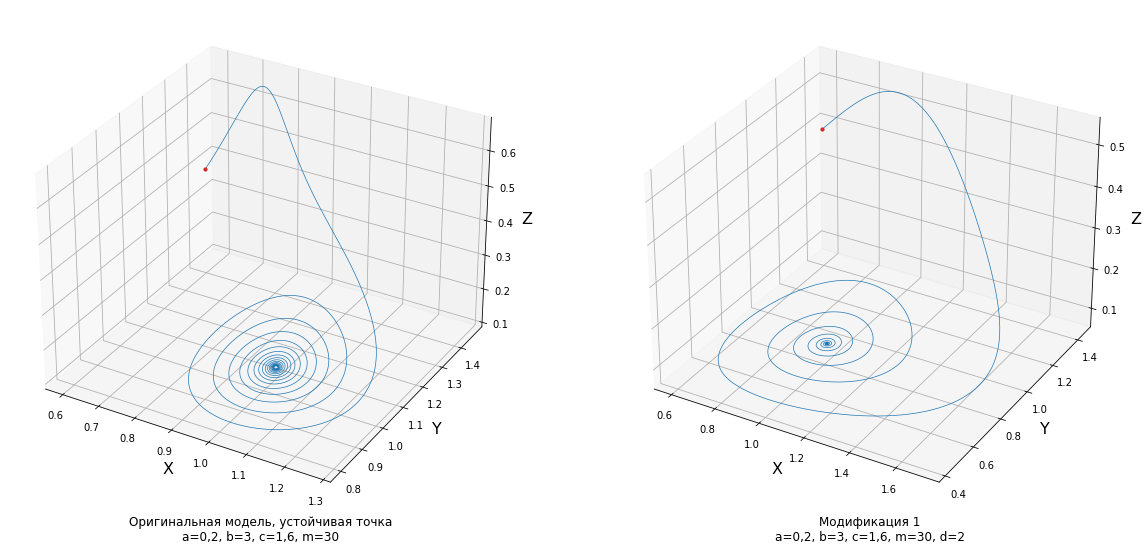

In [769]:
fig = plt.figure()
fig.set_size_inches(20, 10)
get_phase_diagram(orig_focus, fig, 1, 2, 1, get_title('Оригинальная модель, устойчивая точка', orig_focus['params']))
get_phase_diagram(x_with_z_focus, fig, 1, 2, 2, get_title('Модификация 1', x_with_z_focus['params']));

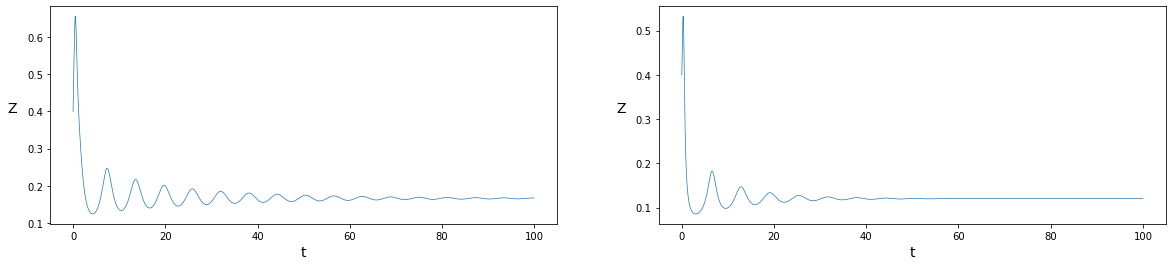

In [770]:
fig = plt.figure()
fig.set_size_inches(20, 4)
get_strike_diagram(orig_focus, fig, 1, 2, 1)
get_strike_diagram(x_with_z_focus, fig, 1, 2, 2);

На графиках видно, что модификация существенно сгладила траекторию в фазовом пространстве.\
Хоть и частота появления всплесков стачечной активности на начальном этапе осталась практически такой же, колебания значения переменной Z затухли гораздо быстрее и система пришла в точку равновесия раньше.

### 2.2. Предельный цикл типа А

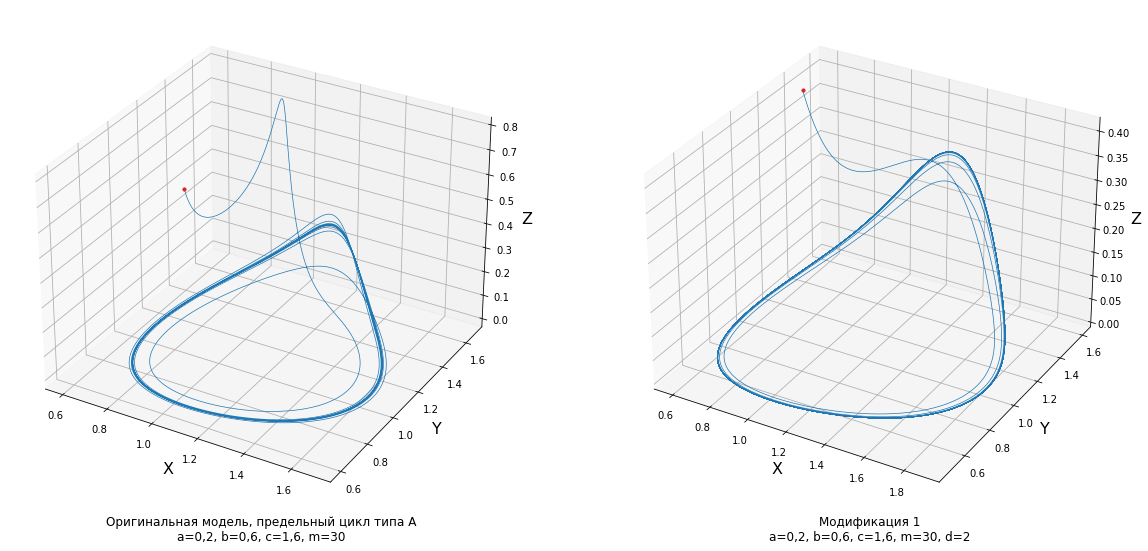

In [771]:
fig = plt.figure()
fig.set_size_inches(20, 10)
get_phase_diagram(orig_limit_cycle_a, fig, 1, 2, 1, get_title('Оригинальная модель, предельный цикл типа А', orig_limit_cycle_a['params']))
get_phase_diagram(x_with_z_limit_cycle_a, fig, 1, 2, 2, get_title('Модификация 1', x_with_z_limit_cycle_a['params']));

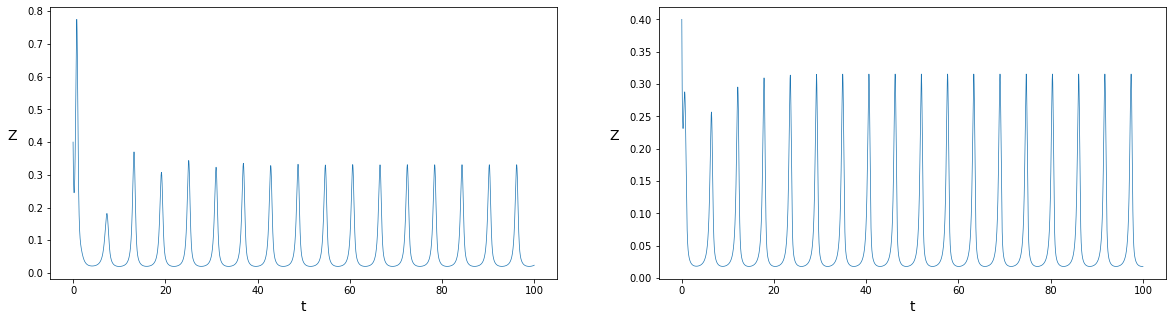

In [772]:
fig = plt.figure()
fig.set_size_inches(20, 5)
get_strike_diagram(orig_limit_cycle_a, fig, 1, 2, 1)
get_strike_diagram(x_with_z_limit_cycle_a, fig, 1, 2, 2);

Из графиков видно, что модификация существенно сгладила начальный всплек и обеспечила чуть более быстрый выход на предельную траекторию.\
Также стоит отметить что сама траектория стала немного шире, однако частота колебаний числа бастующих рабочих и максимальное их значение остались примерно на том же уровне.

### 2.3. Предельный цикл типа Б

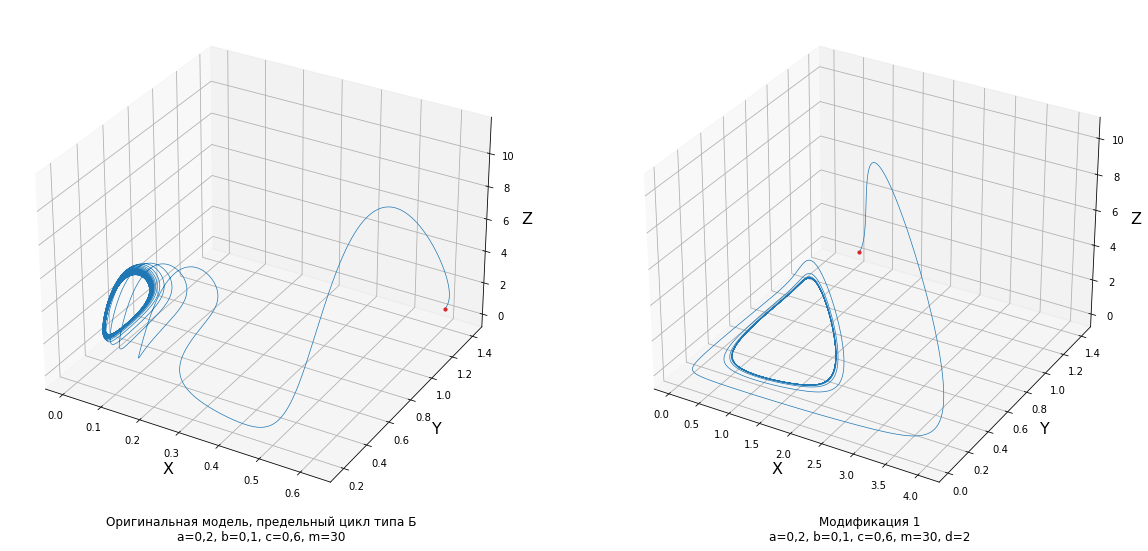

In [773]:
fig = plt.figure()
fig.set_size_inches(20, 10)
get_phase_diagram(orig_limit_cycle_b, fig, 1, 2, 1, get_title('Оригинальная модель, предельный цикл типа Б', orig_limit_cycle_b['params']))
get_phase_diagram(x_with_z_limit_cycle_b, fig, 1, 2, 2, get_title('Модификация 1', x_with_z_limit_cycle_b['params']));

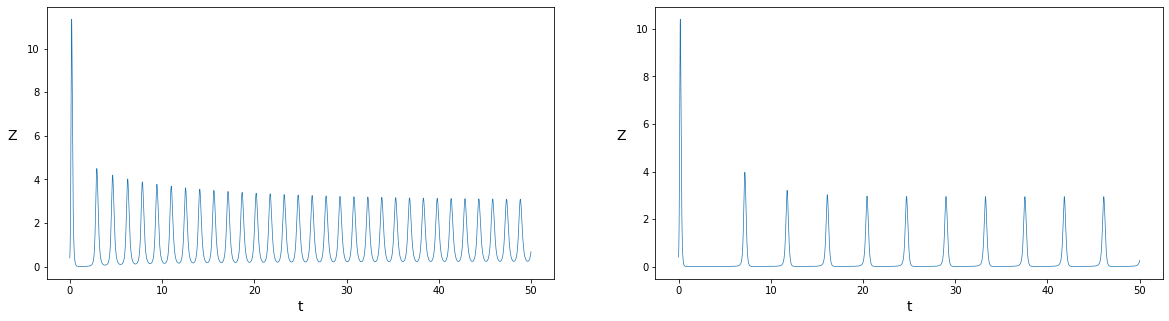

In [774]:
fig = plt.figure()
fig.set_size_inches(20, 5)
get_strike_diagram(orig_limit_cycle_b, fig, 1, 2, 1)
get_strike_diagram(x_with_z_limit_cycle_b, fig, 1, 2, 2);

В этом случае модификация вместо предельного цикла типа Б (плоскость которого совпадает с координатной плоскостью Y, Z), выдает предельный цикл близкий к типу А.\
Это объясняется тем что в оригинальной модели, после выхода на предельную траекторию, власти практически переставали реагировать на протест, а в модифицированной версии повышение числа бастующих является стимулом для введения контрмер.\
Также стоит отметить что пиковые значения стачечной активности остались на том же уровне, а вот частота их появлений существенно уменьшилась.

### 2.4. Странный аттрактор типа А

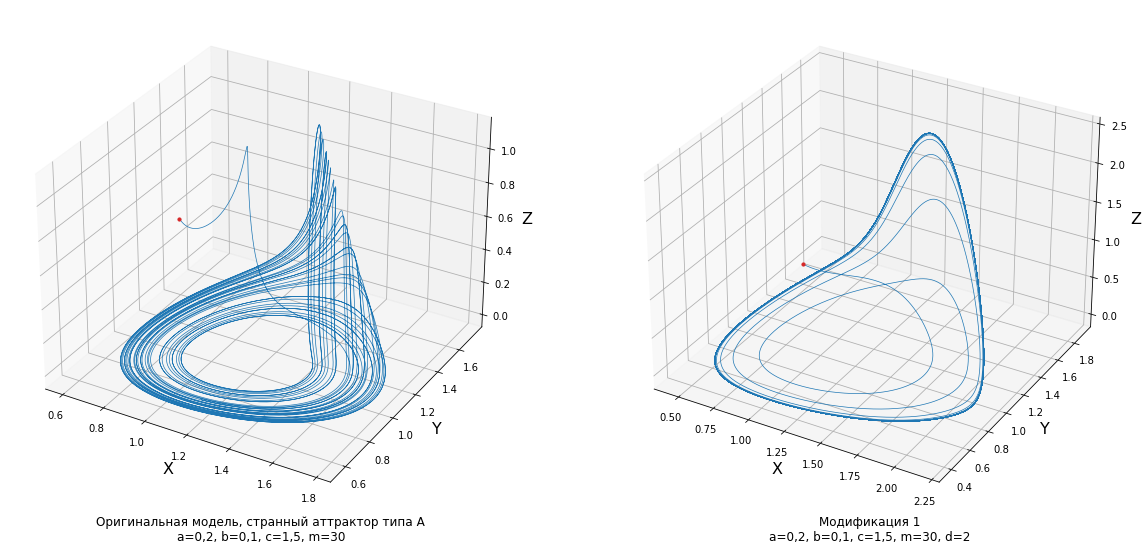

In [775]:
fig = plt.figure()
fig.set_size_inches(20, 10)
get_phase_diagram(orig_strange_attractor_a, fig, 1, 2, 1, get_title('Оригинальная модель, странный аттрактор типа А', orig_strange_attractor_a['params']))
get_phase_diagram(x_with_z_strange_attractor_a, fig, 1, 2, 2, get_title('Модификация 1', x_with_z_strange_attractor_a['params']));

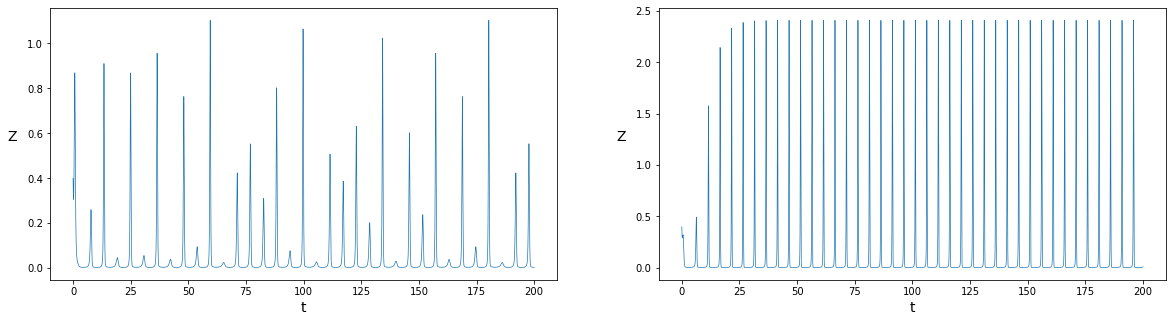

In [776]:
fig = plt.figure()
fig.set_size_inches(20, 5)
get_strike_diagram(orig_strange_attractor_a, fig, 1, 2, 1)
get_strike_diagram(x_with_z_strange_attractor_a, fig, 1, 2, 2);

Здесь модификация дает стабилизирующий эффект, траектория системы теперь выглядит как предельный цикл.\
Максимальные значения числа бастующих рабочих на каждой итерации примерно одинаковые, как и временные интервалы между ними.

### 2.5. Странный аттрактор типа Б

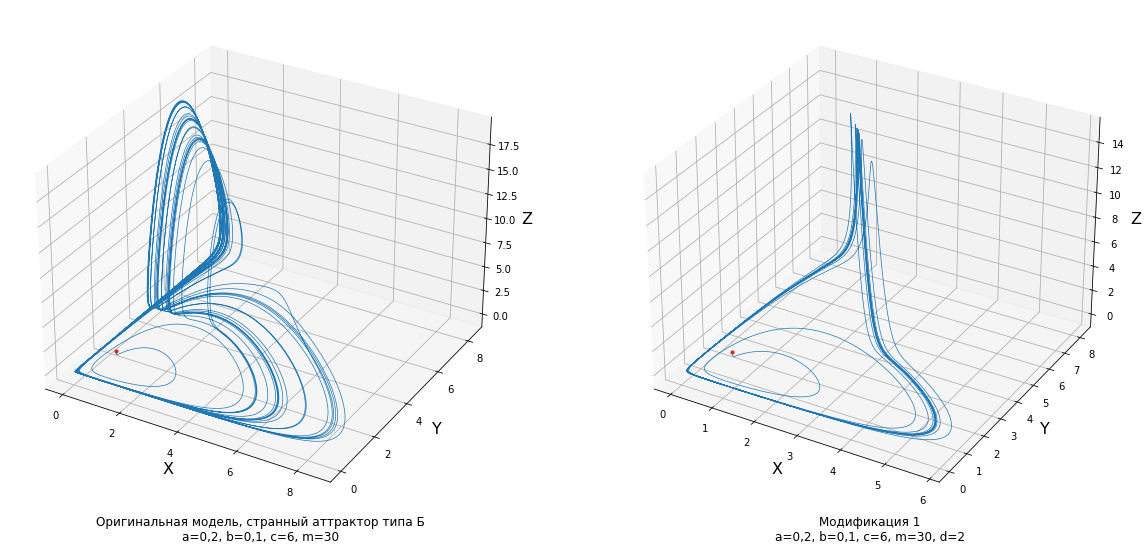

In [777]:
fig = plt.figure()
fig.set_size_inches(20, 10)
get_phase_diagram(orig_strange_attractor_b, fig, 1, 2, 1, get_title('Оригинальная модель, странный аттрактор типа Б', orig_strange_attractor_b['params']))
get_phase_diagram(x_with_z_strange_attractor_b, fig, 1, 2, 2, get_title('Модификация 1', x_with_z_strange_attractor_b['params']));

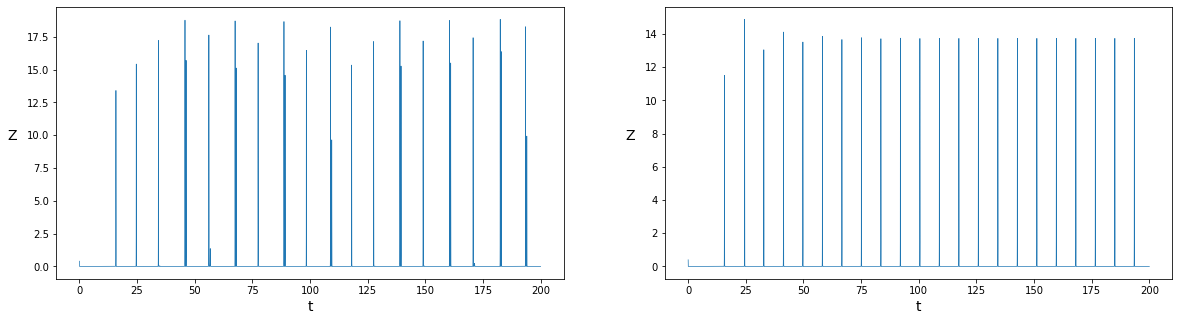

In [778]:
fig = plt.figure()
fig.set_size_inches(20, 5)
get_strike_diagram(orig_strange_attractor_b, fig, 1, 2, 1)
get_strike_diagram(x_with_z_strange_attractor_b, fig, 1, 2, 2);

Как и в предыдущем случае, здесь мы снова видим скорее предельный цикл, а не странный аттрактор.\
Несмотря на причудливую форму траектории, частоту колебаний и амплитуду можно назвать постоянной.

# 3. Модификация вторая: влияние излишнего давления властей на рост стачечной активности

В основе этой модификации лежит идея о том, что несоизмеримо жесткая реакция на протестную активность приводит к ее росту, а не уменьшению. Например: если небольшое количество бастующих рабочих с умеренными требованиями разогнать с помощью войск, то это только подстегнет остальных к стачке.\
В качестве показателя соизмеримости контрмер властей мы возьмем отношение X к Z. При этом это соотношение будет умножаться на уже существующий коэффициент b. То есть, если давления властей X больше чем число бастующих рабочих Z, то вклад каждодневных причин, подталкивающих рабочего к стачке, будет больше b и наоборот. Для выравнивания отношения X к Z мы также введем новый коэффициент f.

\begin{equation*}
 \begin{cases}
     \frac{dX}{dt} = -X + X \cdot Y\\
     \frac{dY}{dt} = Y - X \cdot Y + a \cdot Y^2 - Y \cdot Z\\
     \frac{dZ}{dt} = b \cdot \frac{f \cdot X}{Z} - m \cdot (c-Y) \cdot Z
 \end{cases}
\end{equation*}

Рассчитаем значения X, Y, Z и перейдем к сравнению.

In [779]:
def zf_tens(X, Y, Z, params):
    return params['b']  * params['f'] * (X/Z) - params['m']*(params['c'] - Y)*Z

In [780]:
tens_focus = calculate_values({'a': 0.2, 'b': 3, 'c': 1.6, 'm': 30, 'f': 1.1}, xf, yf, zf_tens)
tens_limit_cycle_a = calculate_values({'a': 0.2, 'b': 0.6, 'c': 1.6, 'm': 30, 'f': 1.1}, xf, yf, zf_tens)
tens_limit_cycle_b = calculate_values({'a': 0.2, 'b': 0.1, 'c': 0.6, 'm': 30, 'f': 1.1}, xf, yf, zf_tens, max_t=50)
tens_strange_attractor_a = calculate_values({'a': 0.2, 'b': 0.1, 'c': 1.5, 'm': 30, 'f': 1.1}, xf, yf, zf_tens, max_t=200)
tens_strange_attractor_b = calculate_values({'a': 0.2, 'b': 0.1, 'c': 6, 'm': 30, 'f': 1.1}, xf, yf, zf_tens, max_t=200)

### 3.1. Устойчивая точка

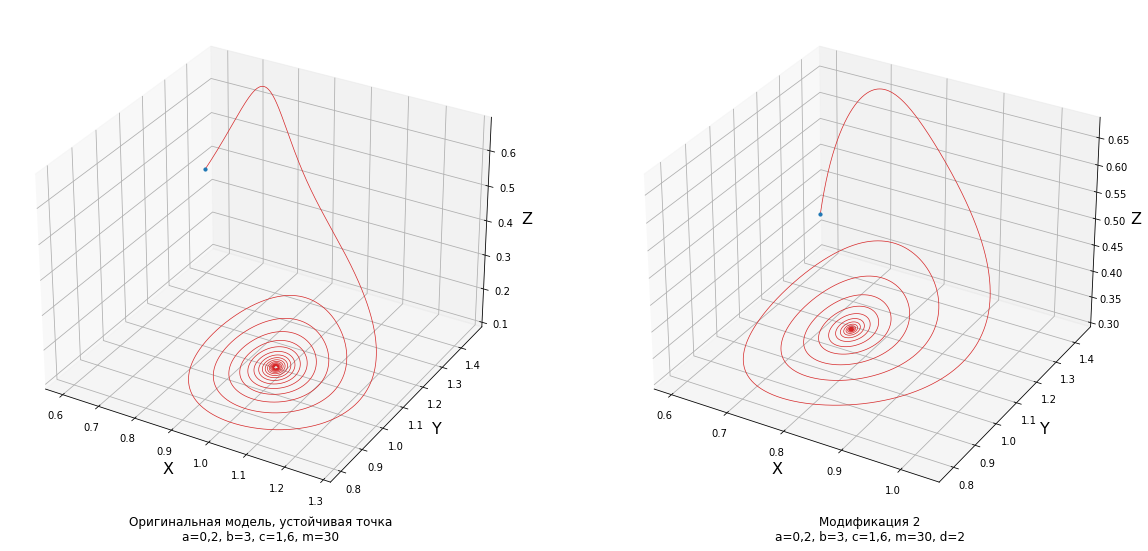

In [781]:
fig = plt.figure()
fig.set_size_inches(20, 10)
get_phase_diagram(orig_focus, fig, 1, 2, 1, get_title('Оригинальная модель, устойчивая точка', orig_focus['params']), 'C3')
get_phase_diagram(tens_focus, fig, 1, 2, 2, get_title('Модификация 2', x_with_z_focus['params']), 'C3');

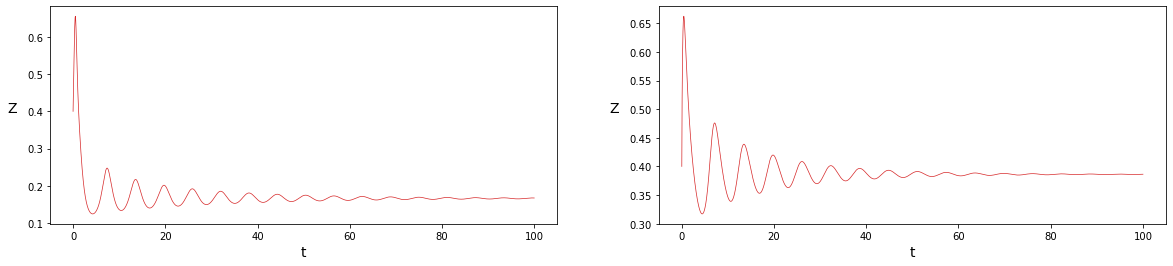

In [782]:
fig = plt.figure()
fig.set_size_inches(20, 4)
get_strike_diagram(orig_focus, fig, 1, 2, 1, color='C3')
get_strike_diagram(tens_focus, fig, 1, 2, 2, color='C3');

В первом случае видно, что максимумы стачечной активности увеличились, однако обе системы в итоге пришли к равновесию за сравнимое время.\
Также стоит отметить, что на начальном этапе траектория немного сгладилась по сравнению с оригинальной моделью.

### 3.2. Предельный цикл типа А

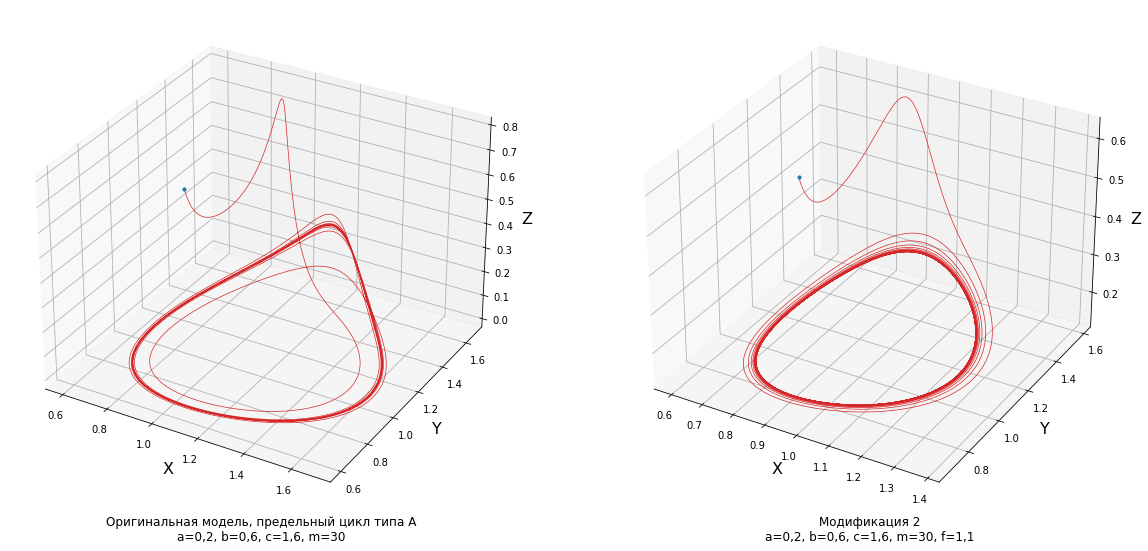

In [783]:
fig = plt.figure()
fig.set_size_inches(20, 10)
get_phase_diagram(orig_limit_cycle_a, fig, 1, 2, 1, get_title('Оригинальная модель, предельный цикл типа А', orig_limit_cycle_a['params']), 'C3')
get_phase_diagram(tens_limit_cycle_a, fig, 1, 2, 2, get_title('Модификация 2', tens_limit_cycle_a['params']), 'C3');

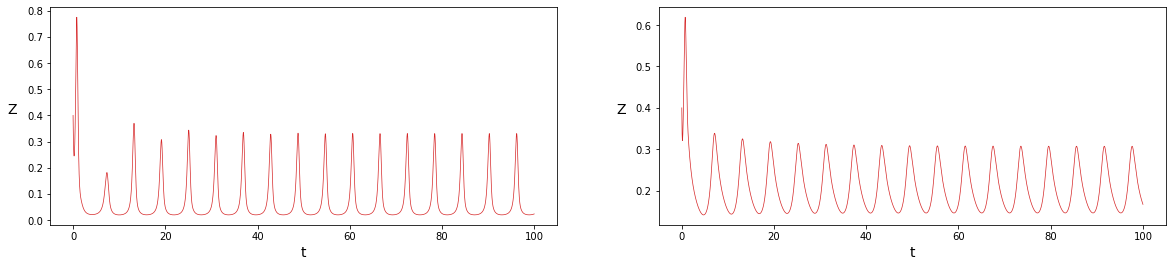

In [784]:
fig = plt.figure()
fig.set_size_inches(20, 4)
get_strike_diagram(orig_limit_cycle_a, fig, 1, 2, 1, color='C3')
get_strike_diagram(tens_limit_cycle_a, fig, 1, 2, 2, color='C3');

Здесь мы наблюдаем более гладкую траекторию системы как на начальной стадии, так и на стадии выхода на предельную траекторию.\
Максимальные значения стачечной активности остались на том же уровне, а вот сами пики немного сгладились. Видно что нарастание числа бастующих рабочих происхоит более резко, чем падение.

### 3.3. Предельный цикл типа Б

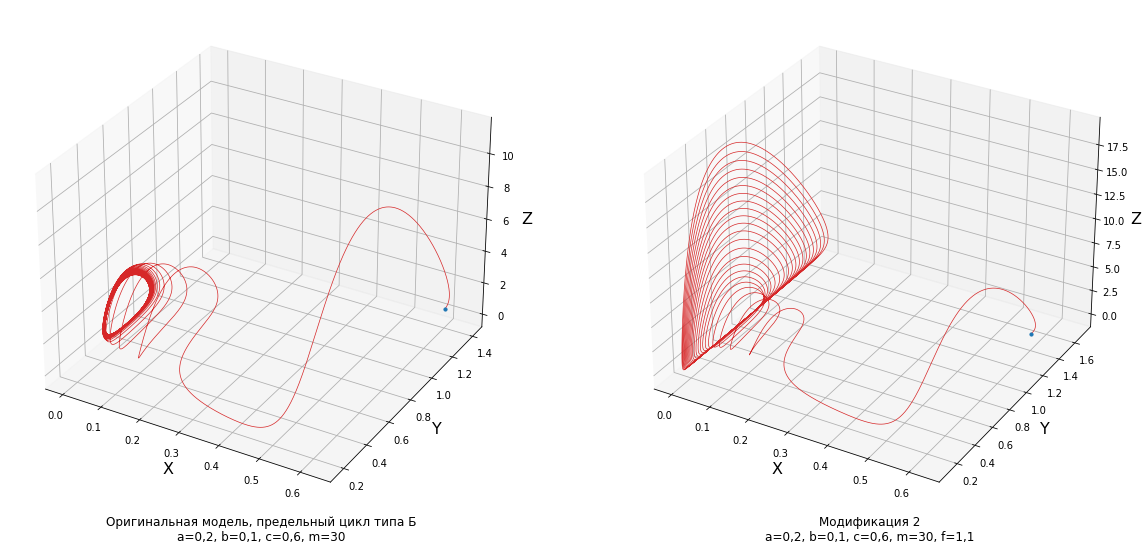

In [785]:
fig = plt.figure()
fig.set_size_inches(20, 10)
get_phase_diagram(orig_limit_cycle_b, fig, 1, 2, 1, get_title('Оригинальная модель, предельный цикл типа Б', orig_limit_cycle_b['params']), 'C3')
get_phase_diagram(tens_limit_cycle_b, fig, 1, 2, 2, get_title('Модификация 2', tens_limit_cycle_b['params']), 'C3');

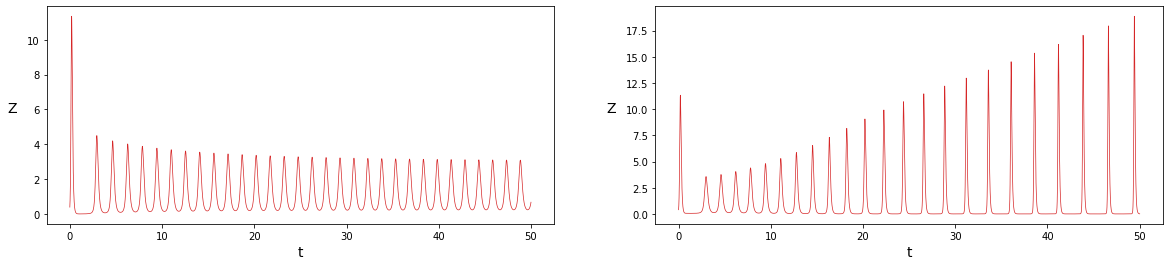

In [786]:
fig = plt.figure()
fig.set_size_inches(20, 4)
get_strike_diagram(orig_limit_cycle_b, fig, 1, 2, 1, color='C3')
get_strike_diagram(tens_limit_cycle_b, fig, 1, 2, 2, color='C3');

В этом случае наблюдается интересная вещь: похоже что после выхода на траекторию, которая была предельной для оригинальной модели, модифицированная модель начинает терять равновесие и мы наблюдаем рост бесконтрольный стачечной активности на каждом новом витке.\
Это происходит из-за того что при нулевом (или околонулевого) значении X, значение коэффициента b полностью игнорируется и происходит расбалансировка системы.

### 3.4. Странный аттрактор типа А

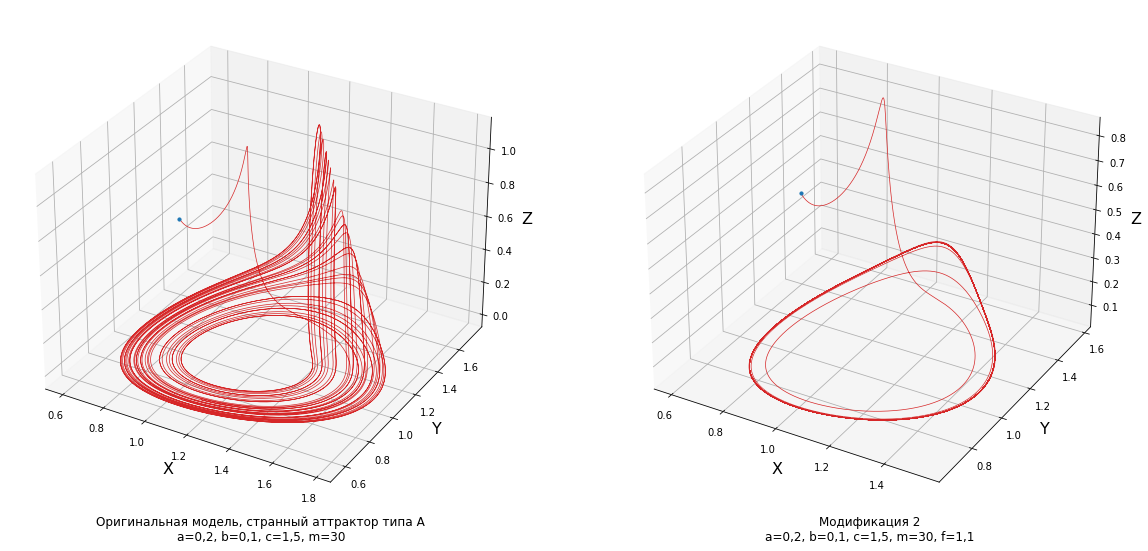

In [788]:
fig = plt.figure()
fig.set_size_inches(20, 10)
get_phase_diagram(orig_strange_attractor_a, fig, 1, 2, 1, get_title('Оригинальная модель, странный аттрактор типа А', orig_strange_attractor_a['params']), 'C3')
get_phase_diagram(tens_strange_attractor_a, fig, 1, 2, 2, get_title('Модификация 2', tens_strange_attractor_a['params']), 'C3');

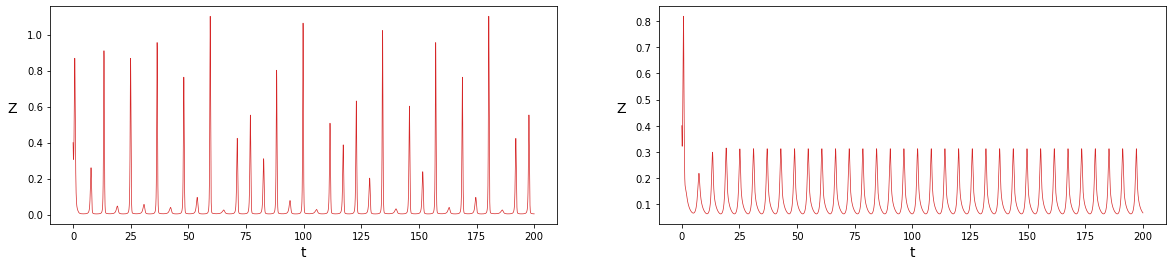

In [789]:
fig = plt.figure()
fig.set_size_inches(20, 4)
get_strike_diagram(orig_strange_attractor_a, fig, 1, 2, 1, color='C3')
get_strike_diagram(tens_strange_attractor_a, fig, 1, 2, 2, color='C3');

Как и в случае с первой модификацией, вторая модификация превратила странный аттрактор в предельный цикл.\
Частота колебаний и максимальные значения выглядят одинаковыми.

### 3.5. Странный аттрактор типа Б

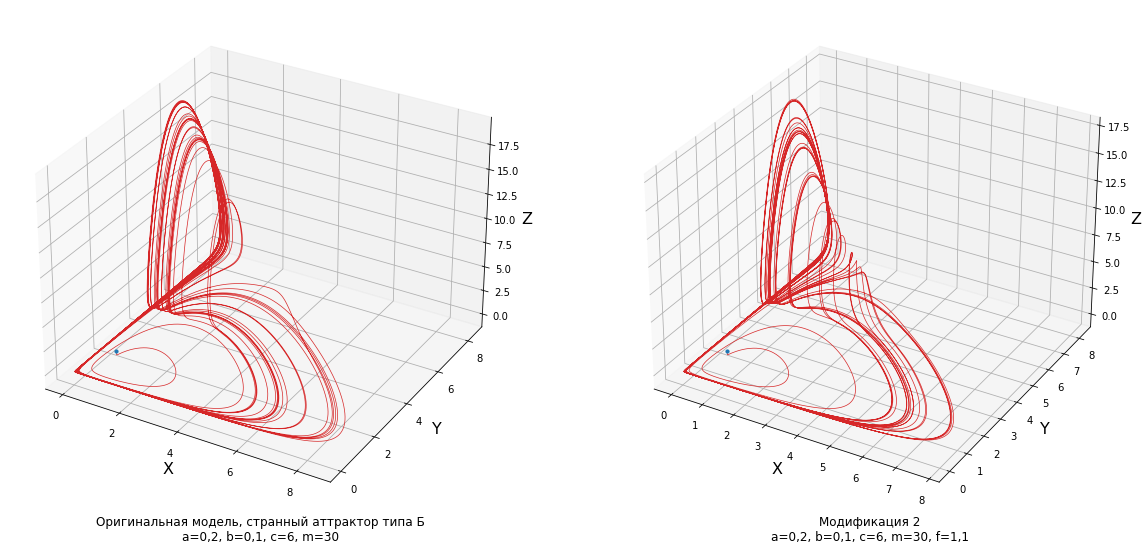

In [752]:
fig = plt.figure()
fig.set_size_inches(20, 10)
get_phase_diagram(orig_strange_attractor_b, fig, 1, 2, 1, get_title('Оригинальная модель, странный аттрактор типа Б', orig_strange_attractor_b['params']), 'C3')
get_phase_diagram(tens_strange_attractor_b, fig, 1, 2, 2, get_title('Модификация 2', tens_strange_attractor_b['params']), 'C3');

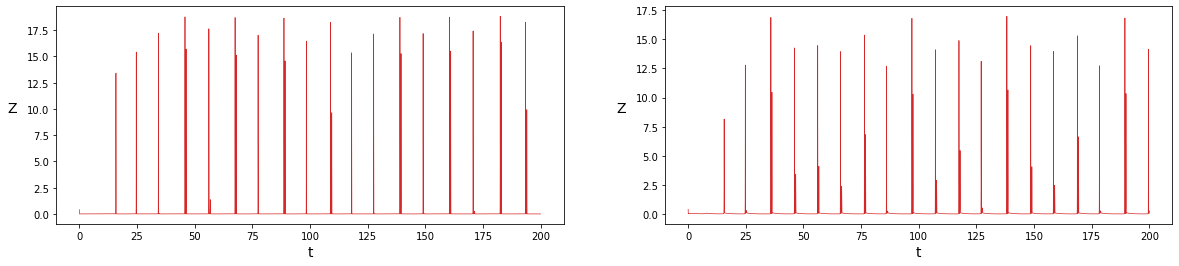

In [686]:
fig = plt.figure()
fig.set_size_inches(20, 4)
get_strike_diagram(orig_strange_attractor_b, fig, 1, 2, 1, color='C3')
get_strike_diagram(tens_strange_attractor_b, fig, 1, 2, 2, color='C3');

В этом случая вторая модификация произвела самый настоящий странный аттрактор типа Б, причем даже с более хаотичной траекторией, чем у оригинальной модели.

# 4. Выводы

* Первая модификация, добавляющая влияние числа бастующих рабочих на активность властей, делает систему менее хаотичной, позволяет быстрее достичь точки равновесия или обеспечить выход на предельную траекторию. В некоторых случаях, при прочих равных параметрах, траектория системы качественно видоизменяется в сторону более стабильной. Все это вполне соотносится со здравым смыслом: если власти меняют свою активность под действием сразу двух факторов, это приводит к более адекватным и своевременным контрмерам.

* Вторая модификация, которая учитывает влияние излишнего давления властей на рост стачечной активности, дает разные результаты. В одних случаях мы видим сглаживание траектории системы с увеличением амплитуды, в других ее качественное изменение в сторону более стабильного состояния, а в третьих вообще бесконтрольный рост стачечной активности. Я думаю, что такая модификация имеет право на существование, потому как если в случае, когда рабочие не сталкивались с неоправданной жесткостью со стороны властей, поводов к стачке у них будет гораздо меньше. Как мне кажется, исследование влияния неправданных и излешних контрмер в отношении протестной активности заслуживает дальнейшего изучения.